## 改造(時間遅れ変数、クロスタームの追加を別のコードで)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
import matplotlib.figure as figure
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn import metrics

#LSTMの呼び出し
# 同じディレクトリに LSTMwithAttention.py が存在する場合
import LSTMwithAttention
from LSTMwithAttention import LSTMWithOptionalAttention, Attention


def bo_lstm_hyperparams(datasest, max_time_delay,
                       validation_method='cv', bo_iteration_number=15, display_flag=False):
    
    
    # ハイパーパラメータの探索候補
    seq_length = [10, 50, 100, 300] #sliding_windowのサイズ
    hidden_dim = [2, 4, 8, 16, 32] #隠れ層の数(小さめに設定)
    batch_size = [4, 8, 16, 32]
    lr= [1e-5, 1e-4, 1e-3, 1e-2] 
    dropout_rate = [0.2, 0.3, 0.4, 0.5]
    use_attention = [True, False]  # Attention層を使うかどうかを選択 (True or False)
        
    # 実験計画法の条件
    doe_number_of_selecting_samples = 15  # 選択するサンプル数
    doe_number_of_random_searches = 100  # ランダムにサンプルを選択して D 最適基準を計算する繰り返し回数
    # BOの設定
    bo_iterations = np.arange(0, bo_iteration_number + 1)
    bo_gp_fold_number = 5 # BOのGPを構築するためのcvfold数
    bo_number_of_selecting_samples = 1  # 選択するサンプル数
    #bo_regression_method = 'gpr_kernels'  # gpr_one_kernel', 'gpr_kernels'
    bo_regression_method = 'gpr_one_kernel'  # gpr_one_kernel', 'gpr_kernels'
    bo_kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
    acquisition_function = 'PTR'  # 'PTR', 'PI', 'EI', 'MI'
    target_range = [1, 100]  # PTR
    relaxation = 0.01  # EI, PI
    delta = 10 ** -6  # MI
    
    # 解空間の作成
    parameter_candidates = []
    for window_size in seq_length:
        for hidden in hidden_dim:
            for batch in batch_size:
                for learning_rate in lr:
                    for attention in use_attention:
                            for drop in dropout_rate:
                                parameter_candidates.append([window_size, hidden, batch, learning_rate,
                                                                         attention, drop])
                                
    all_candidate_combinations_df =  pd.DataFrame(parameter_candidates)
    clm_name = ['window_size', 'hidden_dim', 'batch_size', 'learning_rate',
               'attention', 'dropout_rate']
    
    all_candidate_combinations_df.columns = clm_name
    
    
    numerical_variable_numbers = np.array([0, 1, 2, 3, 5])
    category_variable_numbers = np.array([4])
    category_columns = all_candidate_combinations_df.columns[category_variable_numbers]
    #ワンホット変換
    numerical_x = all_candidate_combinations_df.iloc[:, numerical_variable_numbers]
    
    category_x = all_candidate_combinations_df.iloc[:, category_variable_numbers].astype(int)
    #dummy_x = pd.get_dummies(category_x, columns=category_columns).astype(int)
    params_df = pd.concat([numerical_x, category_x], axis=1)
    
    #########################ここから#########################
    
    
    # ベイズ最適化の繰り返し
    for bo_iter in bo_iterations:
        if display_flag:
            print(f'Bayesian optimization iteration : {bo_iter + 1} / {bo_iteration_number}')
    #    print('='*10)
        if bo_iter == 0: # 最初の試行ではD最適基準を計算
            # D最適基準の計算
            autoscaled_params_df = (params_df - params_df.mean(axis=0)) / params_df.std(axis=0, ddof=1) # 計算のために標準化
            all_indexes = list(range(autoscaled_params_df.shape[0])) # indexを取得
    
            np.random.seed(11) # 乱数を生成するためのシードを固定
            for random_search_number in range(doe_number_of_random_searches):
                # 1. ランダムに候補を選択
                new_selected_indexes = np.random.choice(all_indexes, doe_number_of_selecting_samples, replace=False)
                new_selected_samples = autoscaled_params_df.iloc[new_selected_indexes, :]
                # 2. D 最適基準を計算
                xt_x = np.dot(new_selected_samples.T, new_selected_samples)
                d_optimal_value = np.linalg.det(xt_x) 
                # 3. D 最適基準が前回までの最大値を上回ったら、選択された候補を更新
                if random_search_number == 0:
                    best_d_optimal_value = d_optimal_value.copy()
                    selected_sample_indexes = new_selected_indexes.copy()
                else:
                    if best_d_optimal_value < d_optimal_value:
                        best_d_optimal_value = d_optimal_value.copy()
                        selected_sample_indexes = new_selected_indexes.copy()
            selected_sample_indexes = list(selected_sample_indexes) # リスト型に変換
            
            # 選択されたサンプル、選択されなかったサンプル
            selected_params_df = params_df.iloc[selected_sample_indexes, :]  # 選択されたサンプル
            true_selected_params_df = all_candidate_combinations_df.iloc[selected_sample_indexes, :]
            bo_params_df = selected_params_df.copy() # BOのGPモデル構築用データを作成
            remaining_indexes = np.delete(all_indexes, selected_sample_indexes)  # 選択されなかったサンプルのインデックス
            remaining_params_df = params_df.iloc[remaining_indexes, :]  # 選択されなかったサンプル
            true_remaining_params_df = all_candidate_combinations_df.iloc[remaining_indexes, :]
    
            # 選択された全候補でGMRの計算
            params_with_score_df = params_df.copy() # cvのscoreが含まれるdataframe
            params_with_score_df['score'] = np.nan # 初期値はnanを設定
    
        else: # 2回目以降では前回の結果をもとにする
            selected_sample_indexes = next_samples_df.index # 提案サンプルのindex
            selected_params_df = params_df.loc[selected_sample_indexes, :] # 次に計算するサンプル
            true_selected_params_df = all_candidate_combinations_df.loc[selected_sample_indexes, :] # 次に計算するサンプル
            bo_params_df = pd.concat([bo_params_df, selected_params_df], axis=0) # BOのGPモデル構築用データは前回のデータと提案サンプルをマージする
            remaining_params_df = params_df.loc[params_with_score_df['score'].isna(), :] # 選択されなかったサンプル
            remaining_params_df = remaining_params_df.drop(index=selected_sample_indexes)
            true_remaining_params_df = all_candidate_combinations_df.loc[params_with_score_df['score'].isna(), :] # 選択されなかったサンプル
            true_remaining_params_df = true_remaining_params_df.drop(index=selected_sample_indexes)
    
        # 選ばれたサンプル（パラメータの組み合わせ）を一つずつ計算する
        for i_n, selected_params_idx in enumerate(selected_sample_indexes):
            selected_params = true_selected_params_df.loc[selected_params_idx, :] # サンプルの選択
            
            #データ拡張の選択
            selected_seq_length = selected_params['window_size']
            selected_hidden_dim = selected_params['hidden_dim']
            selected_batch_size = selected_params['batch_size']
            selected_lr = selected_params['learning_rate']
            selected_attention = selected_params['attention']
            selected_dropout_late = selected_params['dropout_rate']

            data = dataset.values.astype('float32')

            inputs = data[:, 1:]
            targets = data[:, 0]
            
            #ここで入力の次元が決まります
            input_dim = dataset.shape[1] - 1

            #window_sizeごとにデータを区切ります
            input_sequences, target_sequences = create_sequences(inputs, targets, selected_seq_length)

            X_train, X_test, y_train, y_test = train_test_split(
                input_sequences, target_sequences, test_size=0.3, shuffle=False)

            train_inputs_tensor = torch.tensor(X_train).float()
            train_targets_tensor = torch.tensor(y_train).float().unsqueeze(1)

            #test_inputs_tensor = torch.tensor(X_test).float()
            #test_targets_tensor = torch.tensor(y_test).float().unsqueeze(1)

            train_dataset = TensorDataset(train_inputs_tensor, train_targets_tensor)
            #test_dataset = TensorDataset(test_inputs_tensor, test_targets_tensor)

            train_loader = DataLoader(train_dataset, batch_size=int(selected_batch_size), shuffle=False)
            #test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            
            model = LSTMWithOptionalAttention(input_dim, int(selected_hidden_dim), output_dim, 
                                              selected_attention, selected_dropout_late)

            # -------------------------------
            # 学習準備（変更なし）
            # -------------------------------
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=selected_lr)
            
            
            train_r2_scores = []
            train_losses = []

            for epoch in range(num_epochs):
                model.train()
                epoch_loss = 0
                all_train_predictions = []
                all_true_train_targets = []

                for inputs, targets in train_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    optimizer.zero_grad()
                    outputs, _ = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)

                    # 訓練データの予測値を保存
                    all_train_predictions.extend(outputs.detach().cpu().numpy().flatten())
                    all_true_train_targets.extend(targets.detach().cpu().numpy().flatten())

                avg_loss = epoch_loss / len(train_dataset)
                train_losses.append(avg_loss)

                # 訓練データ全体のR2スコアを計算
                train_r2 = r2_score(all_true_train_targets, all_train_predictions)
                #train_r2 = r2lm(all_true_train_targets, all_train_predictions)
                train_r2_scores.append(train_r2)

            params_with_score_df.loc[selected_params_idx, 'score'] = train_r2 # データの保存
        if display_flag:
            print('Best score :', params_with_score_df['score'].max())
            print('='*10)
        
        # 最後はBOの計算をしないためbreak
        if bo_iter + 1 == bo_iteration_number:
            break
                
        # Bayesian optimization
        bo_x_data = bo_params_df.copy() # GP学習用データはGMRの結果があるサンプル
        bo_x_prediction = remaining_params_df.copy() # predictionは選択されていない（GMRの結果がない）サンプル
        bo_y_data = params_with_score_df.loc[bo_params_df.index, 'score'] # yはGMRのr2cv
        
        # カーネル 11 種類
        bo_kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
                    ConstantKernel() * RBF() + WhiteKernel(),
                    ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
                    ConstantKernel() * RBF(np.ones(bo_x_data.shape[1])) + WhiteKernel(),
                    ConstantKernel() * RBF(np.ones(bo_x_data.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),
                    ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
                    ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
                    ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
                    ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
                    ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
                    ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]
    
        next_samples = pd.DataFrame([], columns=selected_params_df.columns)  # 次のサンプルを入れる変数を準備
    
        # 次の候補を複数提案する繰り返し工程
        for bo_sample_number in range(bo_number_of_selecting_samples):
            # オートスケーリング
            bo_x_data_std = bo_x_data.std()
            bo_x_data_std[bo_x_data_std == 0] = 1
            autoscaled_bo_y_data = (bo_y_data - bo_y_data.mean()) / bo_y_data.std()
            autoscaled_bo_x_data = (bo_x_data - bo_x_data.mean()) / bo_x_data_std
            autoscaled_bo_x_prediction = (bo_x_prediction - bo_x_data.mean()) / bo_x_data_std
            
            # モデル構築
            if bo_regression_method == 'gpr_one_kernel':
                bo_selected_kernel = bo_kernels[bo_kernel_number]
                bo_model = GaussianProcessRegressor(alpha=0, kernel=bo_selected_kernel)
    
            elif bo_regression_method == 'gpr_kernels':
                # クロスバリデーションによるカーネル関数の最適化
                bo_cross_validation = KFold(n_splits=bo_gp_fold_number, random_state=9, shuffle=True) # クロスバリデーションの分割の設定
                bo_r2cvs = [] # 空の list。カーネル関数ごとに、クロスバリデーション後の r2 を入れていきます
                for index, bo_kernel in enumerate(bo_kernels):
                    bo_model = GaussianProcessRegressor(alpha=0, kernel=bo_kernel)
                    estimated_bo_y_in_cv = np.ndarray.flatten(cross_val_predict(bo_model, autoscaled_bo_x_data, autoscaled_bo_y_data, cv=bo_cross_validation))
                    estimated_bo_y_in_cv = estimated_bo_y_in_cv * bo_y_data.std(ddof=1) + bo_y_data.mean()
                    bo_r2cvs.append(r2_score(bo_y_data, estimated_bo_y_in_cv))
                optimal_bo_kernel_number = np.where(bo_r2cvs == np.max(bo_r2cvs))[0][0]  # クロスバリデーション後の r2 が最も大きいカーネル関数の番号
                optimal_bo_kernel = bo_kernels[optimal_bo_kernel_number]  # クロスバリデーション後の r2 が最も大きいカーネル関数
                
                # モデル構築
                bo_model = GaussianProcessRegressor(alpha=0, kernel=optimal_bo_kernel, random_state=9) # GPR モデルの宣言
                
            bo_model.fit(autoscaled_bo_x_data, autoscaled_bo_y_data)  # モデルの学習
            
            # 予測
            estimated_bo_y_prediction, estimated_bo_y_prediction_std = bo_model.predict(autoscaled_bo_x_prediction, return_std=True)
            estimated_bo_y_prediction = estimated_bo_y_prediction * bo_y_data.std() + bo_y_data.mean()
            estimated_bo_y_prediction_std = estimated_bo_y_prediction_std * bo_y_data.std()
            
            cumulative_variance = np.zeros(bo_x_prediction.shape[0])
            # 獲得関数の計算
            if acquisition_function == 'MI':
                acquisition_function_prediction = estimated_bo_y_prediction + np.log(2 / delta) ** 0.5 * (
                        (estimated_bo_y_prediction_std ** 2 + cumulative_variance) ** 0.5 - cumulative_variance ** 0.5)
                cumulative_variance = cumulative_variance + estimated_bo_y_prediction_std ** 2
            elif acquisition_function == 'EI':
                acquisition_function_prediction = (estimated_bo_y_prediction - max(bo_y_data) - relaxation * bo_y_data.std()) * \
                                                norm.cdf((estimated_bo_y_prediction - max(bo_y_data) - relaxation * bo_y_data.std()) /
                                                            estimated_bo_y_prediction_std) + \
                                                estimated_bo_y_prediction_std * \
                                                norm.pdf((estimated_bo_y_prediction - max(bo_y_data) - relaxation * bo_y_data.std()) /
                                                            estimated_bo_y_prediction_std)
            elif acquisition_function == 'PI':
                acquisition_function_prediction = norm.cdf(
                        (estimated_bo_y_prediction - max(bo_y_data) - relaxation * bo_y_data.std()) / estimated_bo_y_prediction_std)
            elif acquisition_function == 'PTR':
                acquisition_function_prediction = norm.cdf(target_range[1],
                                                        loc=estimated_bo_y_prediction,
                                                        scale=estimated_bo_y_prediction_std
                                                        ) - norm.cdf(target_range[0],
                                                                        loc=estimated_bo_y_prediction,
                                                                        scale=estimated_bo_y_prediction_std)
            acquisition_function_prediction[estimated_bo_y_prediction_std <= 0] = 0
            
            # 保存
            estimated_bo_y_prediction = pd.DataFrame(estimated_bo_y_prediction, bo_x_prediction.index, columns=['estimated_y'])
            estimated_bo_y_prediction_std = pd.DataFrame(estimated_bo_y_prediction_std, bo_x_prediction.index, columns=['std_of_estimated_y'])
            acquisition_function_prediction = pd.DataFrame(acquisition_function_prediction, index=bo_x_prediction.index, columns=['acquisition_function'])
    #        
            # 次のサンプル
            next_samples = pd.concat([next_samples, bo_x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
            
            # x, y, x_prediction, cumulative_variance の更新
            bo_x_data = pd.concat([bo_x_data, bo_x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
            bo_y_data = pd.concat([bo_y_data, estimated_bo_y_prediction.loc[acquisition_function_prediction.idxmax()].iloc[0]], axis=0)
            bo_x_prediction = bo_x_prediction.drop(acquisition_function_prediction.idxmax(), axis=0)
            cumulative_variance = np.delete(cumulative_variance, np.where(acquisition_function_prediction.index == acquisition_function_prediction.iloc[:, 0].idxmax())[0][0])
        next_samples_df = next_samples.copy()
    
    # 結果の保存
    #params_with_score_df.sort_values('score', ascending=False).to_csv('params_with_score.csv')
    print(params_with_score_df)
    params_with_score_df_best = params_with_score_df.sort_values('score', ascending=False).iloc[0, :] # r2が高い順にソー
    #best_r2
    
    optimal_window_size = params_with_score_df_best.iloc[0]
    optimal_hidden_dim = params_with_score_df_best.iloc[1]
    optimal_batch_size = params_with_score_df_best.iloc[2]
    optimal_learning_rate = params_with_score_df_best.iloc[3]
    optimal_dropout_rate = params_with_score_df_best.iloc[4]
    if int(params_with_score_df_best.iloc[5]) == 1:
        optimal_attention = True
    else:
        optimal_attention = False
        
    #optimal_hidden_layer_sizes = hidden_layer_sizes_candidates[int(best_candidate_combination.iloc[0])]
    #optimal_activation = activation_candidates[int(best_candidate_combination.iloc[1])]
    #optimal_alpha = best_candidate_combination.iloc[2]
    #optimal_learning_rate_init = best_candidate_combination.iloc[3]
    
    """
    input_dimが変わらないのであれば、最適化したmodelをreturn
    最適化しないのであれば、最適値をリターン
    """
       
    return optimal_window_size, optimal_hidden_dim, optimal_batch_size, optimal_learning_rate, optimal_dropout_rate, optimal_attention

    
# Calculate r^2 based on the latest measured y-values
# measured_y and estimated_y must be vectors.
def r2lm(measured_y, estimated_y):
    measured_y = np.array(measured_y).flatten()
    estimated_y = np.array(estimated_y).flatten()
    return float(1 - sum((measured_y - estimated_y) ** 2) / sum((measured_y[1:] - measured_y[:-1]) ** 2))

def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
        return np.array(xs), np.array(ys)
        

output_dim=1
num_epochs = 10
dataset = pd.read_csv('sample_dataset.csv', index_col=0)
(optimal_window_size, optimal_hidden_dim, optimal_batch_size, optimal_learning_rate, optimal_dropout_rate, optimal_attention) = bo_lstm_hyperparams(dataset, max_time_delay,
                                                                                                                                                    validation_method='cv', bo_iteration_number=15, display_flag=True)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
from scipy.stats import norm
import matplotlib.pyplot as plt

#LSTMの呼び出し
from LSTMwithAttention import LSTMWithOptionalAttention, Attention

def bo_lstm_hyperparams(datasest, num_epochs, bo_iteration_number=15, display_flag=False):
    
    #固定のパラメータ
    #入力次元
    input_dim = dataset.shape[1] - 1
    
    #出力次元
    output_dim=1
    
    # ハイパーパラメータの探索候補
    seq_length = [10, 50, 100, 300] #sliding_windowのサイズ
    hidden_dim = [2, 4, 8, 16, 32] #隠れ層の数(小さめに設定)
    batch_size = [4, 8, 16, 32]
    lr= [1e-5, 1e-4, 1e-3, 1e-2] 
    dropout_rate = [0.2, 0.3, 0.4, 0.5]
    use_attention = [True, False]  # Attention層を使うかどうかを選択 (True or False)
        
    # 実験計画法の条件
    doe_number_of_selecting_samples = 3  # 選択するサンプル数
    doe_number_of_random_searches = 100  # ランダムにサンプルを選択して D 最適基準を計算する繰り返し回数
    # BOの設定
    bo_iterations = np.arange(0, bo_iteration_number + 1)
    bo_gp_fold_number = 5 # BOのGPを構築するためのcvfold数
    bo_number_of_selecting_samples = 1  # 選択するサンプル数
    #bo_regression_method = 'gpr_kernels'  # gpr_one_kernel', 'gpr_kernels'
    bo_regression_method = 'gpr_one_kernel'  # gpr_one_kernel', 'gpr_kernels'
    bo_kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
    acquisition_function = 'PTR'  # 'PTR', 'PI', 'EI', 'MI'
    target_range = [1, 100]  # PTR
    relaxation = 0.01  # EI, PI
    delta = 10 ** -6  # MI
    
    # 解空間の作成
    parameter_candidates = []
    for window_size in seq_length:
        for hidden in hidden_dim:
            for batch in batch_size:
                for learning_rate in lr:
                    for attention in use_attention:
                            for drop in dropout_rate:
                                parameter_candidates.append([window_size, hidden, batch, learning_rate,
                                                                         attention, drop])
                                
    all_candidate_combinations_df =  pd.DataFrame(parameter_candidates)
    clm_name = ['window_size', 'hidden_dim', 'batch_size', 'learning_rate',
               'attention', 'dropout_rate']
    
    all_candidate_combinations_df.columns = clm_name
    
    
    numerical_variable_numbers = np.array([0, 1, 2, 3, 5])
    category_variable_numbers = np.array([4])
    category_columns = all_candidate_combinations_df.columns[category_variable_numbers]
    #ワンホット変換
    numerical_x = all_candidate_combinations_df.iloc[:, numerical_variable_numbers]
    category_x = all_candidate_combinations_df.iloc[:, category_variable_numbers].astype(int)
    #dummy_x = pd.get_dummies(category_x, columns=category_columns).astype(int)
    params_df = pd.concat([numerical_x, category_x], axis=1)
    
    #########################ここからベイズ最適化#########################
    
    # ベイズ最適化の繰り返し
    for bo_iter in bo_iterations:
        if display_flag:
            print(f'Bayesian optimization iteration : {bo_iter + 1} / {bo_iteration_number}')
    #    print('='*10)
        if bo_iter == 0: # 最初の試行ではD最適基準を計算
            # D最適基準の計算
            autoscaled_params_df = (params_df - params_df.mean(axis=0)) / params_df.std(axis=0, ddof=1) # 計算のために標準化
            all_indexes = list(range(autoscaled_params_df.shape[0])) # indexを取得
    
            np.random.seed(11) # 乱数を生成するためのシードを固定
            for random_search_number in range(doe_number_of_random_searches):
                # 1. ランダムに候補を選択
                new_selected_indexes = np.random.choice(all_indexes, doe_number_of_selecting_samples, replace=False)
                new_selected_samples = autoscaled_params_df.iloc[new_selected_indexes, :]
                # 2. D 最適基準を計算
                xt_x = np.dot(new_selected_samples.T, new_selected_samples)
                d_optimal_value = np.linalg.det(xt_x) 
                # 3. D 最適基準が前回までの最大値を上回ったら、選択された候補を更新
                if random_search_number == 0:
                    best_d_optimal_value = d_optimal_value.copy()
                    selected_sample_indexes = new_selected_indexes.copy()
                else:
                    if best_d_optimal_value < d_optimal_value:
                        best_d_optimal_value = d_optimal_value.copy()
                        selected_sample_indexes = new_selected_indexes.copy()
            selected_sample_indexes = list(selected_sample_indexes) # リスト型に変換
            
            # 選択されたサンプル、選択されなかったサンプル
            selected_params_df = params_df.iloc[selected_sample_indexes, :]  # 選択されたサンプル
            true_selected_params_df = all_candidate_combinations_df.iloc[selected_sample_indexes, :]
            bo_params_df = selected_params_df.copy() # BOのGPモデル構築用データを作成
            remaining_indexes = np.delete(all_indexes, selected_sample_indexes)  # 選択されなかったサンプルのインデックス
            remaining_params_df = params_df.iloc[remaining_indexes, :]  # 選択されなかったサンプル
            true_remaining_params_df = all_candidate_combinations_df.iloc[remaining_indexes, :]
    
            # 選択された全候補でGPRの計算
            params_with_score_df = params_df.copy() # cvのscoreが含まれるdataframe
            params_with_score_df['score'] = np.nan # 初期値はnanを設定
    
        else: # 2回目以降では前回の結果をもとにする
            selected_sample_indexes = next_samples_df.index # 提案サンプルのindex
            selected_params_df = params_df.loc[selected_sample_indexes, :] # 次に計算するサンプル
            true_selected_params_df = all_candidate_combinations_df.loc[selected_sample_indexes, :] # 次に計算するサンプル
            bo_params_df = pd.concat([bo_params_df, selected_params_df], axis=0) # BOのGPモデル構築用データは前回のデータと提案サンプルをマージする
            remaining_params_df = params_df.loc[params_with_score_df['score'].isna(), :] # 選択されなかったサンプル
            remaining_params_df = remaining_params_df.drop(index=selected_sample_indexes)
            true_remaining_params_df = all_candidate_combinations_df.loc[params_with_score_df['score'].isna(), :] # 選択されなかったサンプル
            true_remaining_params_df = true_remaining_params_df.drop(index=selected_sample_indexes)
    
        # 選ばれたサンプル（パラメータの組み合わせ）を一つずつ計算する
        for i_n, selected_params_idx in enumerate(selected_sample_indexes):
            selected_params = true_selected_params_df.loc[selected_params_idx, :] # サンプルの選択
            
            #データ拡張の選択
            selected_seq_length = selected_params['window_size']
            selected_hidden_dim = selected_params['hidden_dim']
            selected_batch_size = selected_params['batch_size']
            selected_lr = selected_params['learning_rate']
            selected_attention = selected_params['attention']
            selected_dropout_late = selected_params['dropout_rate']

            data = dataset.values.astype('float32')

            inputs = data[:, 1:]
            targets = data[:, 0]

            #window_sizeごとにデータを区切ります
            input_sequences, target_sequences = create_sequences(inputs, targets, selected_seq_length)

            inputs_tensor = torch.tensor(input_sequences).float()
            targets_tensor = torch.tensor(target_sequences).float().unsqueeze(1)

            dataset_tensor = TensorDataset(inputs_tensor, targets_tensor)

            train_loader = DataLoader(dataset_tensor, batch_size=int(selected_batch_size), shuffle=False)
            
            model = LSTMWithOptionalAttention(input_dim, int(selected_hidden_dim), output_dim, 
                                              selected_attention, selected_dropout_late)

            # -------------------------------
            # 学習準備（変更なし）
            # -------------------------------
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=selected_lr)
            
            
            train_r2_scores = []
            train_losses = []

            for epoch in range(num_epochs):
                model.train()
                epoch_loss = 0
                all_train_predictions = []
                all_true_train_targets = []

                for inputs, targets in train_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    optimizer.zero_grad()
                    outputs, _ = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)

                    # 訓練データの予測値を保存
                    all_train_predictions.extend(outputs.detach().cpu().numpy().flatten())
                    all_true_train_targets.extend(targets.detach().cpu().numpy().flatten())

                avg_loss = epoch_loss / len(dataset_tensor)
                train_losses.append(avg_loss)

                # 訓練データ全体のR2スコアを計算
                train_r2 = r2_score(all_true_train_targets, all_train_predictions)
                #train_r2 = r2lm(all_true_train_targets, all_train_predictions)
                train_r2_scores.append(train_r2)

            params_with_score_df.loc[selected_params_idx, 'score'] = train_r2 # データの保存
        if display_flag:
            print('Best score :', params_with_score_df['score'].max())
            print('='*10)
        
        # 最後はBOの計算をしないためbreak
        if bo_iter + 1 == bo_iteration_number:
            break
                
        # Bayesian optimization
        bo_x_data = bo_params_df.copy() # GP学習用データはGMRの結果があるサンプル
        bo_x_prediction = remaining_params_df.copy() # predictionは選択されていない（GMRの結果がない）サンプル
        bo_y_data = params_with_score_df.loc[bo_params_df.index, 'score'] # yはGMRのr2cv
        
        # カーネル 11 種類
        bo_kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
                    ConstantKernel() * RBF() + WhiteKernel(),
                    ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
                    ConstantKernel() * RBF(np.ones(bo_x_data.shape[1])) + WhiteKernel(),
                    ConstantKernel() * RBF(np.ones(bo_x_data.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),
                    ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
                    ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
                    ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
                    ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
                    ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
                    ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]
    
        next_samples = pd.DataFrame([], columns=selected_params_df.columns)  # 次のサンプルを入れる変数を準備
    
        # 次の候補を複数提案する繰り返し工程
        for bo_sample_number in range(bo_number_of_selecting_samples):
            # オートスケーリング
            bo_x_data_std = bo_x_data.std()
            bo_x_data_std[bo_x_data_std == 0] = 1
            autoscaled_bo_y_data = (bo_y_data - bo_y_data.mean()) / bo_y_data.std()
            autoscaled_bo_x_data = (bo_x_data - bo_x_data.mean()) / bo_x_data_std
            autoscaled_bo_x_prediction = (bo_x_prediction - bo_x_data.mean()) / bo_x_data_std
            
            # モデル構築
            if bo_regression_method == 'gpr_one_kernel':
                bo_selected_kernel = bo_kernels[bo_kernel_number]
                bo_model = GaussianProcessRegressor(alpha=0, kernel=bo_selected_kernel)
    
            elif bo_regression_method == 'gpr_kernels':
                # クロスバリデーションによるカーネル関数の最適化
                bo_cross_validation = KFold(n_splits=bo_gp_fold_number, random_state=9, shuffle=True) # クロスバリデーションの分割の設定
                bo_r2cvs = [] # 空の list。カーネル関数ごとに、クロスバリデーション後の r2 を入れていきます
                for index, bo_kernel in enumerate(bo_kernels):
                    bo_model = GaussianProcessRegressor(alpha=0, kernel=bo_kernel)
                    estimated_bo_y_in_cv = np.ndarray.flatten(cross_val_predict(bo_model, autoscaled_bo_x_data, autoscaled_bo_y_data, cv=bo_cross_validation))
                    estimated_bo_y_in_cv = estimated_bo_y_in_cv * bo_y_data.std(ddof=1) + bo_y_data.mean()
                    bo_r2cvs.append(r2_score(bo_y_data, estimated_bo_y_in_cv))
                optimal_bo_kernel_number = np.where(bo_r2cvs == np.max(bo_r2cvs))[0][0]  # クロスバリデーション後の r2 が最も大きいカーネル関数の番号
                optimal_bo_kernel = bo_kernels[optimal_bo_kernel_number]  # クロスバリデーション後の r2 が最も大きいカーネル関数
                
                # モデル構築
                bo_model = GaussianProcessRegressor(alpha=0, kernel=optimal_bo_kernel, random_state=9) # GPR モデルの宣言
                
            bo_model.fit(autoscaled_bo_x_data, autoscaled_bo_y_data)  # モデルの学習
            
            # 予測
            estimated_bo_y_prediction, estimated_bo_y_prediction_std = bo_model.predict(autoscaled_bo_x_prediction, return_std=True)
            estimated_bo_y_prediction = estimated_bo_y_prediction * bo_y_data.std() + bo_y_data.mean()
            estimated_bo_y_prediction_std = estimated_bo_y_prediction_std * bo_y_data.std()
            
            cumulative_variance = np.zeros(bo_x_prediction.shape[0])
            # 獲得関数の計算
            if acquisition_function == 'MI':
                acquisition_function_prediction = estimated_bo_y_prediction + np.log(2 / delta) ** 0.5 * (
                        (estimated_bo_y_prediction_std ** 2 + cumulative_variance) ** 0.5 - cumulative_variance ** 0.5)
                cumulative_variance = cumulative_variance + estimated_bo_y_prediction_std ** 2
            elif acquisition_function == 'EI':
                acquisition_function_prediction = (estimated_bo_y_prediction - max(bo_y_data) - relaxation * bo_y_data.std()) * \
                                                norm.cdf((estimated_bo_y_prediction - max(bo_y_data) - relaxation * bo_y_data.std()) /
                                                            estimated_bo_y_prediction_std) + \
                                                estimated_bo_y_prediction_std * \
                                                norm.pdf((estimated_bo_y_prediction - max(bo_y_data) - relaxation * bo_y_data.std()) /
                                                            estimated_bo_y_prediction_std)
            elif acquisition_function == 'PI':
                acquisition_function_prediction = norm.cdf(
                        (estimated_bo_y_prediction - max(bo_y_data) - relaxation * bo_y_data.std()) / estimated_bo_y_prediction_std)
            elif acquisition_function == 'PTR':
                acquisition_function_prediction = norm.cdf(target_range[1],
                                                        loc=estimated_bo_y_prediction,
                                                        scale=estimated_bo_y_prediction_std
                                                        ) - norm.cdf(target_range[0],
                                                                        loc=estimated_bo_y_prediction,
                                                                        scale=estimated_bo_y_prediction_std)
            acquisition_function_prediction[estimated_bo_y_prediction_std <= 0] = 0
            
            # 保存
            estimated_bo_y_prediction = pd.DataFrame(estimated_bo_y_prediction, bo_x_prediction.index, columns=['estimated_y'])
            estimated_bo_y_prediction_std = pd.DataFrame(estimated_bo_y_prediction_std, bo_x_prediction.index, columns=['std_of_estimated_y'])
            acquisition_function_prediction = pd.DataFrame(acquisition_function_prediction, index=bo_x_prediction.index, columns=['acquisition_function'])
    #        
            # 次のサンプル
            next_samples = pd.concat([next_samples, bo_x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
            
            # x, y, x_prediction, cumulative_variance の更新
            bo_x_data = pd.concat([bo_x_data, bo_x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
            bo_y_data = pd.concat([bo_y_data, estimated_bo_y_prediction.loc[acquisition_function_prediction.idxmax()].iloc[0]], axis=0)
            bo_x_prediction = bo_x_prediction.drop(acquisition_function_prediction.idxmax(), axis=0)
            cumulative_variance = np.delete(cumulative_variance, np.where(acquisition_function_prediction.index == acquisition_function_prediction.iloc[:, 0].idxmax())[0][0])
        next_samples_df = next_samples.copy()
    
    # 結果の保存
    #params_with_score_df.sort_values('score', ascending=False).to_csv('params_with_score.csv')
    #print(params_with_score_df)
    params_with_score_df_best = params_with_score_df.sort_values('score', ascending=False).iloc[0, :] # r2が高い順にソー
    #best_r2
    
    optimal_window_size = params_with_score_df_best.iloc[0] #最適な窓サイズ
    optimal_hidden_dim = params_with_score_df_best.iloc[1] #最適な隠れ層サイズ
    optimal_batch_size = params_with_score_df_best.iloc[2] # 最適なバッチサイズ
    optimal_learning_rate = params_with_score_df_best.iloc[3] #最適な学習率
    optimal_dropout_rate = params_with_score_df_best.iloc[4] #最適なドロップアウト率
    if int(params_with_score_df_best.iloc[5]) == 1: #アテンションを適応させるかどうか
        optimal_attention = True
    else:
        optimal_attention = False
    
    """
    input_dimが変わらないのであれば、最適化したmodelをreturn
    最適化しないのであれば、最適値をリターン
    """
    model = LSTMWithOptionalAttention(input_dim, optimal_hidden_dim, output_dim, 
                                              optimal_attention, optimal_dropout_rate)
    #return optimal_window_size, optimal_hidden_dim, optimal_batch_size, optimal_learning_rate, optimal_dropout_rate, optimal_attention
    return model, optimal_window_size, optimal_batch_size

    
# Calculate r^2 based on the latest measured y-values
# measured_y and estimated_y must be vectors.
def r2lm(measured_y, estimated_y):
    measured_y = np.array(measured_y).flatten()
    estimated_y = np.array(estimated_y).flatten()
    return float(1 - sum((measured_y - estimated_y) ** 2) / sum((measured_y[1:] - measured_y[:-1]) ** 2))

def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
    return np.array(xs), np.array(ys)
        

dataset = pd.read_csv('sample_dataset.csv', index_col=0)
#(optimal_window_size, optimal_hidden_dim, optimal_batch_size, optimal_learning_rate, optimal_dropout_rate, optimal_attention) = bo_lstm_hyperparams(dataset,num_epochs = 10, bo_iteration_number=15, display_flag=True)
(model, optimal_window_size, optimal_batch_size, optimal_learning_rate) = bo_lstm_hyperparams(dataset,num_epochs = 10, 
                                                                                              bo_iteration_number=15, display_flag=True)

C:\Users\koishikawa\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Bayesian optimization iteration : 1 / 15


KeyboardInterrupt: 

C:\Users\koishikawa\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Bayesian optimization iteration : 1 / 3
Best score : -0.19786013490489673
Bayesian optimization iteration : 2 / 3


C:\Users\koishikawa\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\koishikawa\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\koishikawa\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\koishikawa\BO_LSTM\bo_lstm.py:307: FutureWarning: Th

Best score : -0.024514036792679494
Bayesian optimization iteration : 3 / 3


C:\Users\koishikawa\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\koishikawa\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\koishikawa\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\koishikawa\BO_LSTM\bo_lstm.py:307: FutureWarning: Th

Best score : -0.024514036792679494


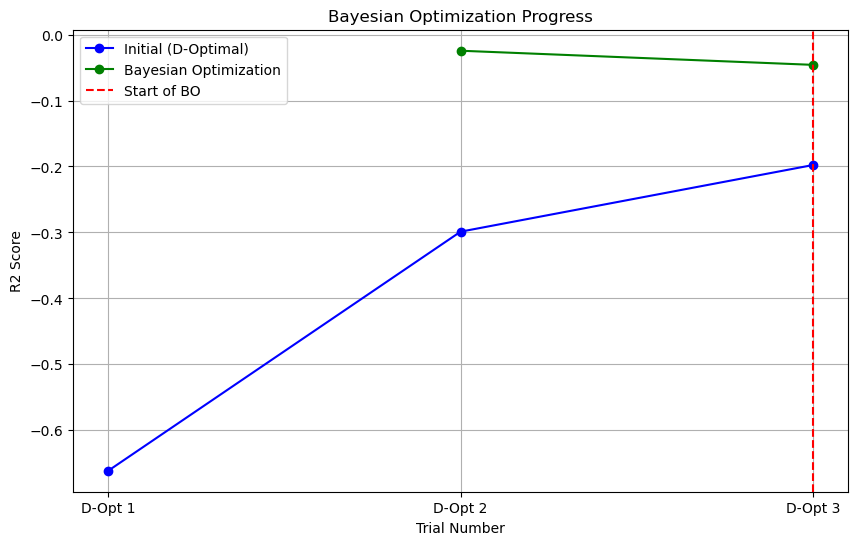

In [1]:
import pandas as pd
from bo_lstm import bo_lstm_hyperparams

#データセットの読み込み
dataset = pd.read_csv('sample_dataset.csv', index_col=0)

(model, optimal_window_size, optimal_batch_size, optimal_learning_rate) = bo_lstm_hyperparams(dataset,num_epochs = 10, 
                                                                                              bo_iteration_number=3, display_flag=True, bo_iteration_plot=True)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

seq_length = int(optimal_window_size)
hidden_dim = int(optimal_hidden_dim)
output_dim = 1
batch_size = int(optimal_batch_size)
num_epochs = 100
use_attention = optimal_attention  # Attention層を使うかどうかを選択 (True or False)
fold_number = 5  # N-fold CV の N


# -------------------------------
# データ読み込みと前処理（変更なし）
# -------------------------------

dataset = pd.read_csv('sample_dataset.csv', index_col=0)

data = dataset.values.astype('float32')

inputs = data[:, 1:]
targets = data[:, 0]

#ここで入力の次元が決まります
input_dim = dataset.shape[1] - 1

def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
    return np.array(xs), np.array(ys)

input_sequences, target_sequences = create_sequences(inputs, targets, seq_length)

X_train, X_test, y_train, y_test = train_test_split(
    input_sequences, target_sequences, test_size=0.3, shuffle=False)

train_inputs_tensor = torch.tensor(X_train).float()
train_targets_tensor = torch.tensor(y_train).float().unsqueeze(1)

test_inputs_tensor = torch.tensor(X_test).float()
test_targets_tensor = torch.tensor(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(train_inputs_tensor, train_targets_tensor)
test_dataset = TensorDataset(test_inputs_tensor, test_targets_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = LSTMWithOptionalAttention(input_dim, hidden_dim, output_dim, use_attention, optimal_dropout_rate)

# -------------------------------
# 学習準備（変更なし）
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=optimal_learning_rate)

# -------------------------------
# モデル学習（Attentionの重みは必要に応じて取得）
# -------------------------------
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)

    avg_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# -------------------------------
# モデル評価（Attentionの重みは必要に応じて保存）
# -------------------------------
model.eval()
test_loss = 0
all_test_predictions = []
all_true_test_targets = []
all_attention_weights = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs, attention_weights = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

        all_test_predictions.extend(outputs.cpu().numpy().flatten())
        all_true_test_targets.extend(targets.cpu().numpy().flatten())
        if use_attention:
            all_attention_weights.extend(attention_weights.cpu().numpy())

average_test_loss = test_loss / len(test_dataset)
r2 = r2_score(all_true_test_targets, all_test_predictions)
#r2 = r2lm(all_true_test_targets, all_test_predictions)
mae = mean_absolute_error(all_true_test_targets, all_test_predictions)
rmse = np.sqrt(mean_squared_error(all_true_test_targets, all_test_predictions))

print(f'\n平均テスト損失: {average_test_loss:.4f}')
print(f'R2: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

# -------------------------------
# プロット（Attentionの可視化はuse_attentionがTrueの場合のみ）
# -------------------------------
# 学習曲線（変更なし）
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# テスト結果（変更なし）
plt.figure(figsize=(12, 6))
plt.plot(all_true_test_targets, label='Actual')
plt.plot(all_test_predictions, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

# Attentionの可視化（use_attentionがTrueの場合のみ）
if use_attention and all_attention_weights:
    first_attention = all_attention_weights[0] # (seq_len, seq_len)
    plt.figure(figsize=(8, 8))
    plt.imshow(first_attention, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('Attention Weights for the First Test Sample')
    plt.xlabel('Input Time Step')
    plt.ylabel('Attention to Time Step')
    plt.xticks(range(seq_length))
    plt.yticks(range(seq_length))
    plt.grid(True)
    plt.show()